In [338]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform Marr-Hildreth edge detection with hysteresis thresholding
def marr_hildreth_edge_detection(image, lower_threshold, higher_threshold, sigma=1.0):
    """
    Performs Marr-Hildreth edge detection with hysteresis thresholding.

    Args:
        image: Grayscale input image (2D array).
        lower_threshold: Lower threshold for hysteresis.
        higher_threshold: Higher threshold for hysteresis.
        sigma: Standard deviation for Gaussian smoothing.

    Returns:
        edges: Binary edge map.
    """
    # Step 1: Smooth the image using a Gaussian filter
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    smoothed_image = cv2.GaussianBlur(image, (0, 0), sigma)

    # Step 2: Compute the Laplacian of the smoothed image
    laplacian = cv2.Laplacian(smoothed_image, cv2.CV_64F)

    # Step 3: Detect zero-crossings
    zero_crossings = np.zeros_like(laplacian, dtype=np.uint8)
    rows, cols = laplacian.shape
    for row in range(1, rows - 1):
        for col in range(1, cols - 1):
            neighbors = laplacian[row - 1:row + 2, col - 1:col + 2].flatten()
            if (laplacian[row, col] > 0 and np.any(neighbors < 0)) or \
               (laplacian[row, col] < 0 and np.any(neighbors > 0)):
                zero_crossings[row, col] = 255

    # Step 4: Compute gradient magnitude for hysteresis thresholding
    sobelx = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)

    # Step 5: Apply hysteresis thresholding
    edges = np.zeros_like(image, dtype=np.uint8)
    strong_edges = (gradient_magnitude > higher_threshold)
    weak_edges = (gradient_magnitude > lower_threshold) & ~strong_edges

    edges[strong_edges] = 255

    # Connect weak edges to strong edges
    for row in range(1, rows - 1):
        for col in range(1, cols - 1):
            if weak_edges[row, col] and np.any(edges[row - 1:row + 2, col - 1:col + 2] == 255):
                edges[row, col] = 255

    return edges



In [339]:
def extract_edge_coordinates(edge_map):
    # Get the coordinates of edge pixels
    edge_coords = np.column_stack(np.where(edge_map == 255))
    return edge_coords

In [340]:
def encode_pixel_values(image, edge_coords, subsample_distance, quantization_level):
    """
    Encodes pixel values from both sides of the edges.

    Args:
        image (numpy.ndarray): Grayscale image.
        edge_coords (list of tuples): Edge pixel coordinates [(y, x), ...].
        subsample_distance (int): Distance between sampled pixels along the edge.
        quantization_level (int): Number of quantization levels (2^q).

    Returns:
        subsampled_values (list): List of quantized pixel values as tuples [(left, right), ...].
    """
    # List to hold the quantized pixel values
    encoded_values = []

    # Iterate through edge coordinates
    for coord in edge_coords:
        y, x = coord

        # Extract pixel values from both sides of the edge
        left_pixel = image[y, x - 1] if x - 1 >= 0 else image[y, x]  # Left of the edge
        right_pixel = image[y, x + 1] if x + 1 < image.shape[1] else image[y, x]  # Right of the edge

        # Apply uniform quantization
        quantized_left = np.round(left_pixel / (256 / quantization_level)) * (256 / quantization_level)
        quantized_right = np.round(right_pixel / (256 / quantization_level)) * (256 / quantization_level)

        # Store the quantized values
        encoded_values.append((quantized_left, quantized_right))

    # Subsample the pixel values (every d-th value along the edge)
    subsampled_values = encoded_values[::subsample_distance]

    return subsampled_values


In [341]:
def compress_data(encoded_values):
    # Convert to a flat list of pixel values
    flat_values = [val for pair in encoded_values for val in pair]

    # Apply differential encoding (store differences)
    compressed_data = [flat_values[0]]  # First value stays the same
    for i in range(1, len(flat_values)):
        compressed_data.append(flat_values[i] - flat_values[i-1])

    return compressed_data


In [342]:
def decode_data(compressed_data, edge_coords, subsample_distance, quantization_level):
    # Decode the differential encoding
    decoded_values = [compressed_data[0]]
    for i in range(1, len(compressed_data)):
        decoded_values.append(decoded_values[-1] + compressed_data[i])

    # Rescale values to original range after quantization
    decoded_values = np.round(np.array(decoded_values) * (256 / quantization_level))

    # Rebuild the edge image with decoded values
    reconstructed_image = np.zeros_like(image)
    for idx, coord in enumerate(edge_coords[::subsample_distance]):
        y, x = coord
        left_val = decoded_values[2*idx]
        right_val = decoded_values[2*idx + 1]

        # Assign decoded pixel values to both sides of the edge
        reconstructed_image[y, x] = left_val
        if x + 1 < image.shape[1]:
            reconstructed_image[y, x + 1] = right_val

    return reconstructed_image


In [343]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
def homogeneous_diffusion(image, max_iterations=10000, tol=1e-5):
    """
    Performs homogeneous diffusion to fill missing values in a 3D image (e.g., RGB).

    Args:
        image (numpy.ndarray): Input image (H x W x C) with missing values (zeros) to be filled.
        max_iterations (int): Maximum number of iterations for the diffusion process.
        tol (float): Convergence tolerance for steady-state solution.

    Returns:
        list: List of images after applying diffusion at specific intervals.
    """
    # Normalize the input image to [0, 1]
    u = image.astype(np.float64) / 255.0
    l = []  # List to store intermediate results

    # Mask of known values (Dirichlet boundary conditions) for each channel
    boundary_mask = (u != 0)  # Boolean mask for each channel

    # Initialize iteration variables
    iteration = 0
    diff = tol + 1  # Initialize with a value larger than tol

    for iteration in tqdm(range(max_iterations)):
        # Create a copy of the current state for comparison
        u_prev = u.copy()

        # Compute the update term using `u_prev` for all channels
        update_term = (
            u_prev[2:, 1:-1, :] + u_prev[:-2, 1:-1, :] +  # Vertical neighbors
            u_prev[1:-1, 2:, :] + u_prev[1:-1, :-2, :] -  # Horizontal neighbors
            4 * u_prev[1:-1, 1:-1, :]                     # Central pixel
        )

        # Update `u` where `boundary_mask` is False
        u[1:-1, 1:-1, :] += 0.1 * update_term * (~boundary_mask[1:-1, 1:-1, :])

        # Clip values to [0, 1]
        u = np.clip(u, 0, 1)

        # Compute the maximum change across all pixels and channels
        diff = np.max(np.abs(u - u_prev))

        # Save intermediate images at specific intervals
        if iteration % 1000 == 0:
            l.append(u.copy())

        # Break if the change is smaller than the tolerance
        if diff < tol:
            break

    print(f"Diffusion converged after {iteration} iterations with diff = {diff:.5f}")
    return l





3557it [00:00, 115279.59it/s]


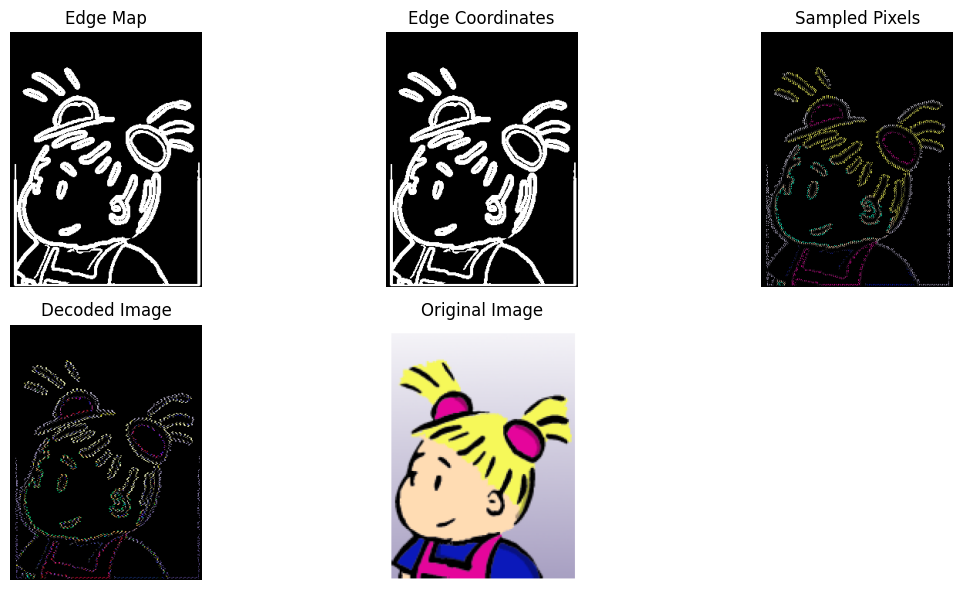

100%|██████████| 10000/10000 [00:45<00:00, 218.83it/s]


Diffusion converged after 9999 iterations with diff = 0.00003


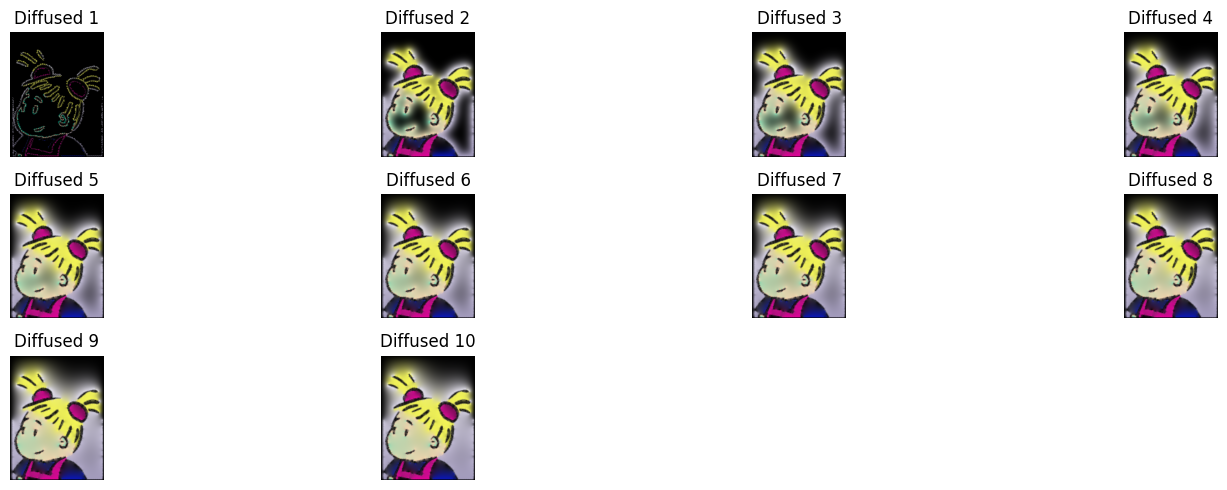

In [344]:
from tqdm import tqdm
def visualize_process_image(image, low_threshold, high_threshold, subsample_distance, quantization_level):
    # Step 1: Edge Detection
    edge_map = marr_hildreth_edge_detection(image, low_threshold, high_threshold)
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.imshow(edge_map, cmap='gray')
    plt.title("Edge Map")
    plt.axis('off')

    # Step 2: Extract Edge Coordinates
    edge_coords = extract_edge_coordinates(edge_map)
    edge_coords_image = np.zeros_like(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    for y, x in edge_coords:
        edge_coords_image[y, x] = 255
    plt.subplot(2, 3, 2)
    plt.imshow(edge_coords_image, cmap='gray')
    plt.title("Edge Coordinates")
    plt.axis('off')

    # Step 3: Encode Pixel Values Along the Edge
    encoded_values = encode_pixel_values(image, edge_coords, subsample_distance, quantization_level)
    sampled_image = np.zeros_like(image)

    # Iterate through edge coordinates and place encoded pixel values
    for idx, coord in tqdm(enumerate(edge_coords[::subsample_distance])):
        y, x = coord
        if idx < len(encoded_values):  # Ensure within bounds
            quantized_left, quantized_right = encoded_values[idx]
            sampled_image[y, x - 1 if x - 1 >= 0 else x] = quantized_left
            sampled_image[y, x + 1 if x + 1 < image.shape[1] else x] = quantized_right
    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(sampled_image, cv2.COLOR_BGR2RGB))
    plt.title("Sampled Pixels")
    plt.axis('off')


    # Step 4: Compress the Encoded Data
    compressed_data = compress_data(encoded_values)

    # Step 5: Decode the Data
    decoded_image = decode_data(compressed_data, edge_coords, subsample_distance, quantization_level)
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(decoded_image, cv2.COLOR_BGR2RGB))
    plt.title("Decoded Image")
    plt.axis('off')

    # Original image for comparison
    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    diffused_images = homogeneous_diffusion(sampled_image)  # Get the list of images

    # Determine the number of images
    num_images = len(diffused_images)

    # Create subplots with an appropriate layout
    plt.figure(figsize=(15, 5))  # Adjust figure size as needed
    rows = (num_images + 3) // 4  # Calculate rows assuming 4 images per row

    for idx, image in enumerate(diffused_images):
        plt.subplot(rows, 4, idx + 1)  # Create subplots (4 images per row)
        image = (image * 255).astype(np.uint8)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Display the image in grayscale
        plt.title(f"Diffused {idx + 1}")  # Add a title for each image
        plt.axis('off')  # Turn off axes for clarity

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()
    return edge_map, edge_coords, encoded_values, compressed_data, decoded_image

# Example usage
image = cv2.imread('/content/cartoon.png')
low_threshold = 64
high_threshold = 128
subsample_distance = 5
quantization_level = 128

edge_map, edge_coords, encoded_values, compressed_data, decoded_image = visualize_process_image(
    image, low_threshold, high_threshold, subsample_distance, quantization_level
)



